In [1]:
list.of.packages <- c("ggplot2","tidyverse","dplyr","hrbrthemes","ggpubr","ggrepel","scales")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org")

invisible(lapply(list.of.packages, library, character.only = TRUE))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




### Database with one row for each publication-country association

In [2]:
path <- "../5_Final_databases/output/database_multi_rows_each_paper_one_per_country.csv"
df <- read_csv(path)
sprintf("%i x %i dataframe", nrow(df), ncol(df))

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  title = col_character(),
  ISO_3 = col_character(),
  Region = col_character(),
  authors = col_character(),
  source = col_character(),
  doi = col_character(),
  abstract = col_character(),
  author_keywords = col_character(),
  model = col_character(),
  scopus_number = col_character(),
  WOS_number = col_character()
)

See spec(...) for full column specifications.



[1] "4884 x 53 dataframe"

### Importing CAIT Database
Based on https://www.climatewatchdata.org/data-explorer/historical-emissions?historical-emissions-data-sources=cait&historical-emissions-gases=all-ghg&historical-emissions-regions=All%20Selected&historical-emissions-sectors=total-including-lucf&page=1

In [3]:
path_CAIT <- "../0_Reference_files/CAIT_GHG_2016.csv"

In [4]:
df_CAIT <- read_csv(path_CAIT)
sprintf("%i x %i dataframe", nrow(df_CAIT), ncol(df_CAIT))
head(df_CAIT,1)

Parsed with column specification:
cols(
  ISO_3 = col_character(),
  Country = col_character(),
  `Data source` = col_character(),
  Sector = col_character(),
  Gas = col_character(),
  Unit = col_character(),
  GHG_incl_landuse = col_double()
)



[1] "195 x 7 dataframe"

ISO_3,Country,Data source,Sector,Gas,Unit,GHG_incl_landuse
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
AFG,Afghanistan,CAIT,Total including LUCF,All GHG,MtCO2e,95.53


### Count publications and GHG emissions associated to each ISO3 and respectively the relative proportion of the database

In [5]:
options(scipen=10000)

data <- df %>%
        select(ISO_3,Region)%>%
        group_by(ISO_3,Region)%>%
        summarise(count_papers = n())%>%
        ungroup()%>%
        inner_join(df_CAIT, by ='ISO_3')%>%
        mutate(ratio_papers = round(count_papers /4691,digit=4),
               ratio_GHG_incl_landuse = round(GHG_incl_landuse / sum(GHG_incl_landuse), digit=4))
head(data,2)
sprintf("%i x %i dataframe", nrow(data), ncol(data))                                    

ISO_3,Region,count_papers,Country,Data source,Sector,Gas,Unit,GHG_incl_landuse,ratio_papers,ratio_GHG_incl_landuse
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
AFG,Asia,1,Afghanistan,CAIT,Total including LUCF,All GHG,MtCO2e,95.53,0.0002,0.0020
AGO,Africa,1,Angola,CAIT,Total including LUCF,All GHG,MtCO2e,138.85,0.0002,0.0029


[1] "131 x 11 dataframe"

### Plot

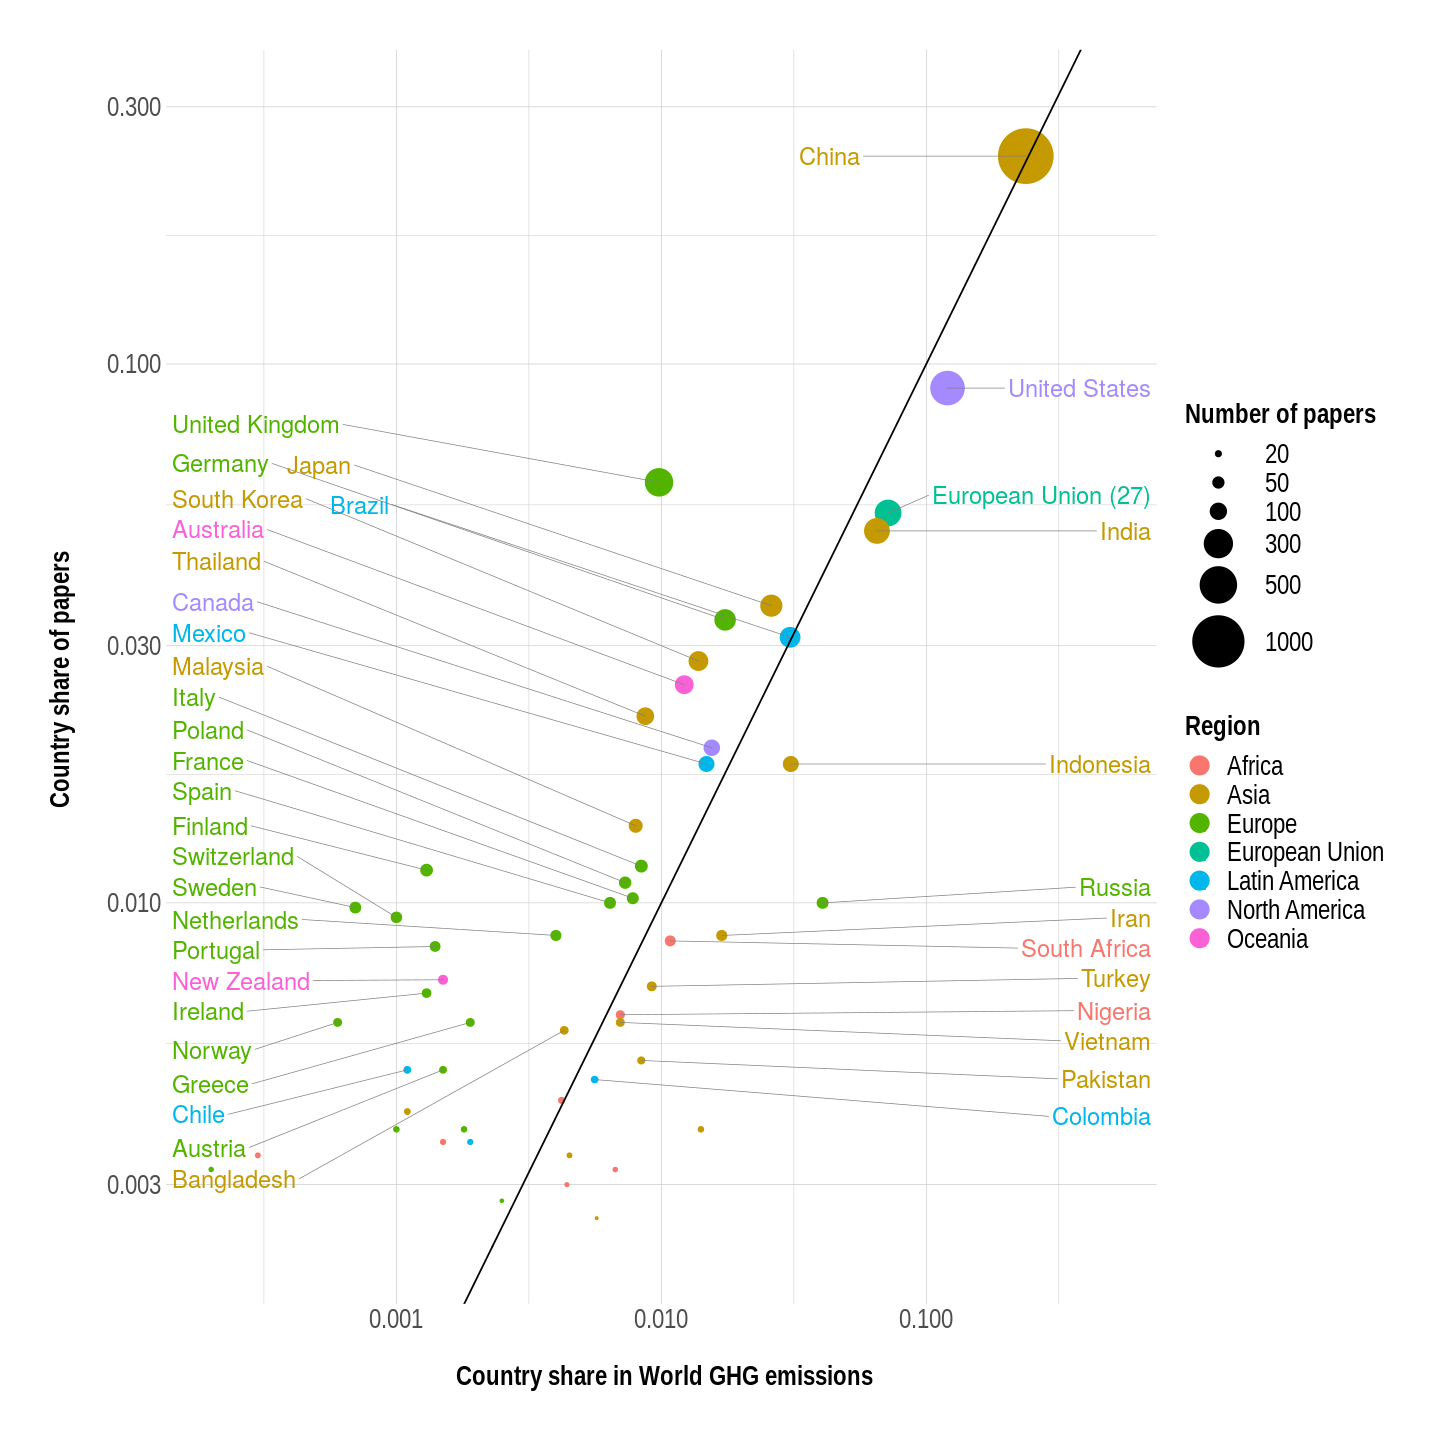

In [6]:
options(repr.plot.width=12, repr.plot.height=12)

plot <- ggplot(data%>% filter(count_papers>10), aes(x=ratio_GHG_incl_landuse, y=ratio_papers, size =count_papers, color = Region, label = Country)) +
                  geom_point(alpha=2) +
                  scale_size(range = c(0.01, 15), breaks=c(10,20,50,100,300,500,1000), name="Number of papers") +
                  scale_fill_manual(values=c('Asia'='darkorange',
                                             'European Union'='#7CAE00',
                                             'Europe'='seagreen4',
                                             'North America'='darkblue',
                                             'Latin America'='dodgerblue2',
                                             'Africa'='orchid',
                                             'Oceania'='#CD9600', 
                                             'Antarctica'='#CAB2D6'))+
                  theme_ipsum() +
                  geom_text_repel(
                                    data          = subset(data, count_papers>20 & ratio_GHG_incl_landuse > ratio_papers),
                                    nudge_x       = 0.2 - log10(subset(data, count_papers>20 & ratio_GHG_incl_landuse > ratio_papers)$ratio_GHG_incl_landuse),
                                    segment.size  = 0.2,
                                    segment.color = "grey50",
                                    direction     = "y",
                                    hjust         = 0,
                                    size=5
                                  ) +
                  geom_text_repel(
                            data = subset(data, count_papers> 20 & 
                                                ratio_GHG_incl_landuse < ratio_papers),
                            nudge_x = log10(subset(data, count_papers>20 & ratio_GHG_incl_landuse < ratio_papers)$ratio_GHG_incl_landuse),
                            direction    = "y",
                            segment.size  = 0.2,
                            segment.color = "grey50", 
                            hjust = 1,
                            size=5
                          ) +
                  scale_x_continuous(name="\n Country share in World GHG emissions", 
                                     limits = c(NA, 0.50), trans='log10') +
                  scale_y_continuous(name="Country share of papers \n",limits=c(NA, 0.30),trans ='log10') +
                  geom_abline(intercept = 0, slope = 1) +
                  theme(legend.title = element_text(size = 16,face ="bold"),
                        legend.text = element_text(size = 16),
                        legend.position="right",
                        axis.text.x = element_text(size = 16),
                        axis.text.y = element_text(size = 16),
                        axis.title.x = element_text(size = 16, hjust = 0.5,face ="bold"),
                        axis.title.y = element_text(size = 16, hjust = 0.5,face ="bold")
                              )+
                  guides(color = guide_legend(override.aes = list(shape = 19, size=5)))

plot

In [7]:
ggsave('./output/Fig2_comparison_papers_emissions.png', height=12, width=12, plot=plot)